# [Exploration 20] Segmentation map으로 도로 이미지 만들기

Pix2Pix를 사용해 도로 segmentation map를 생성합니다.

---

## 프로젝트 목표
---
- Pix2Pix 아키텍쳐를 이해한다.
- Unet, generator, discriminator레이어를 구성한다.


## 프로젝트 설명
---
1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.


## 1. 데이터 불러오기 및 전처리

In [1]:
import tensorflow as tf
import numpy as np
import cv2 

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/'
train_data_path = data_path+'train/'
val_data_path = data_path+'val/'

print("number of train examples :", len(os.listdir(train_data_path)))
print("number of validation examples :", len(os.listdir(val_data_path)))

number of train examples : 1000
number of validation examples : 5


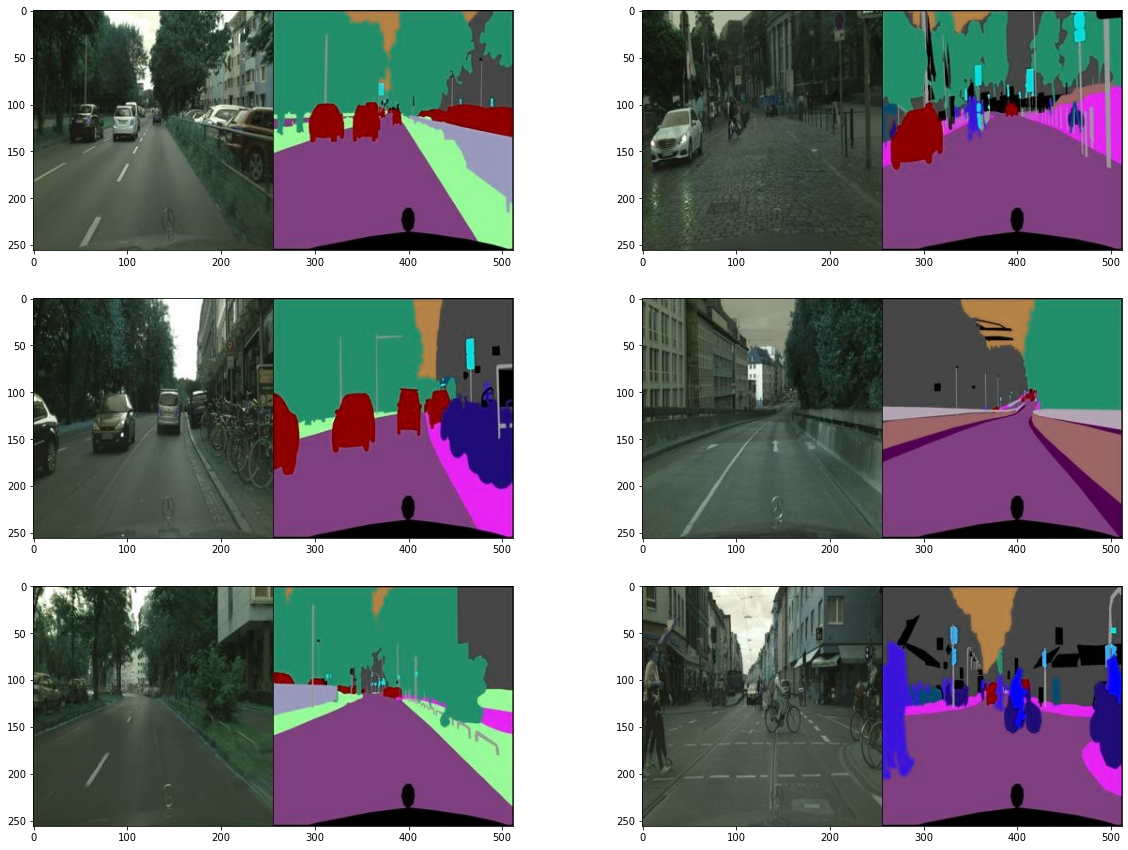

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 이미지의 크기 확인

In [4]:
f = train_data_path + os.listdir(train_data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- 이미지를 2개로 나누어 사용 (가로축 기준 분할)

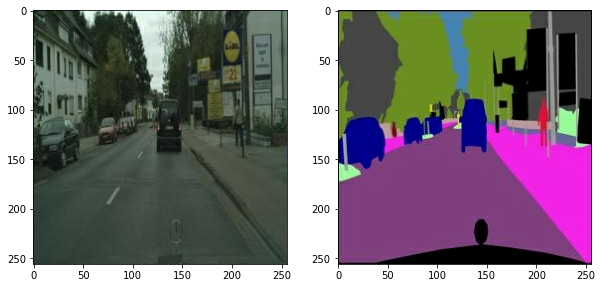

In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

- train 데이터가 1000개이기 때문에 학습을 위해 augmentation을 이용해 데이터셋을 증가

In [6]:
!pip install tensorflow-gpu==2.1-rc2

In [9]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


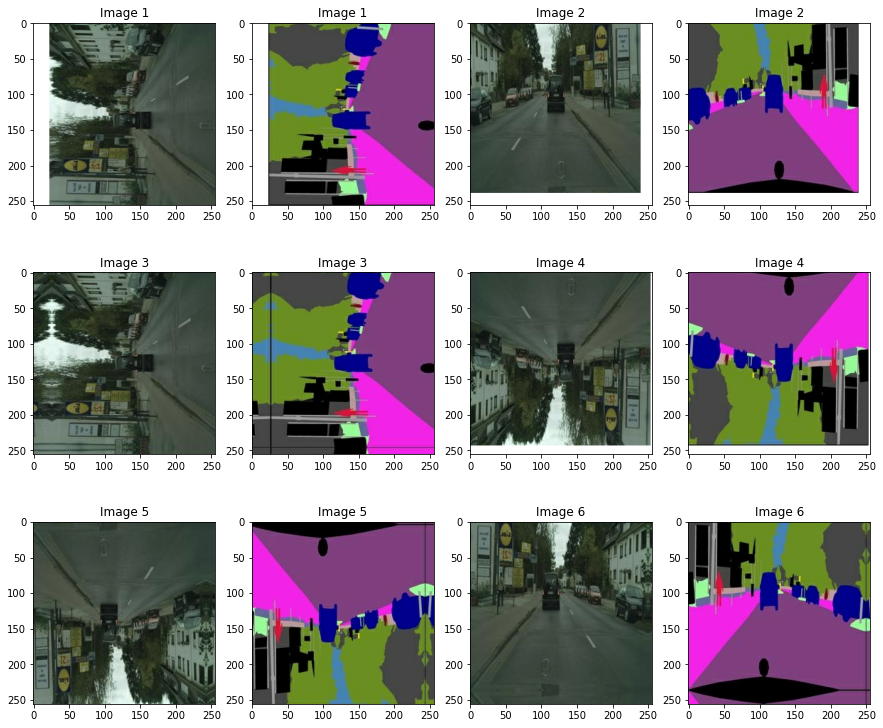

In [10]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

- 이미지 자르기, 뒤집기, 회전을 적용
- train dataset 전체에 해당 augmentation 적용 

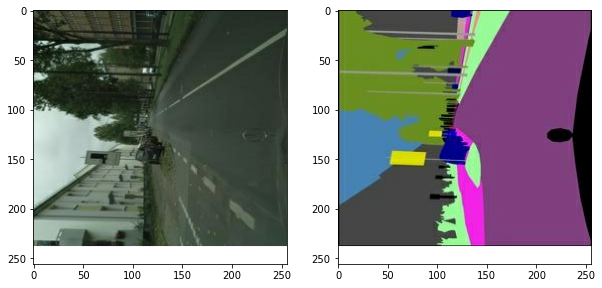

In [11]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 2-1. Generator 구성
- Pix2Pix의 구조를 구현
- skip connection을 추가한 U-Net 구조로 구성

In [13]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [14]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [15]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [16]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [17]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [18]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [19]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_8 (EncodeBlock)    (None, 128, 128, 64) 3072        input_3[0][0]                    
__________________________________________________________________________________________________
encode_block_9 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block_8[0][0]             
__________________________________________________________________________________________________
encode_block_10 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_9[0][0]             
____________________________________________________________________________________________

## 2-2. Discriminator 구성
- Pix2Pix의 구조를 구현

In [20]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [21]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_30 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [22]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [23]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

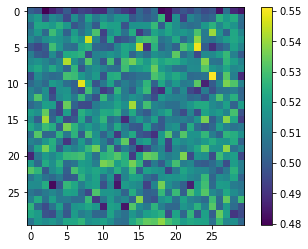

In [24]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 3. 모델 학습

In [25]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [26]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [27]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [28]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8838                     
L1_loss:0.3113                     
Discriminator_loss:1.2025

EPOCH[1] - STEP[20]                     
Generator_loss:1.0424                     
L1_loss:0.2609                     
Discriminator_loss:1.2111

EPOCH[1] - STEP[30]                     
Generator_loss:1.0523                     
L1_loss:0.2872                     
Discriminator_loss:0.9724

EPOCH[1] - STEP[40]                     
Generator_loss:1.7905                     
L1_loss:0.2258                     
Discriminator_loss:0.6683

EPOCH[1] - STEP[50]                     
Generator_loss:1.9275                     
L1_loss:0.2389                     
Discriminator_loss:0.7370

EPOCH[1] - STEP[60]                     
Generator_loss:1.9155                     
L1_loss:0.2655                     
Discriminator_loss:0.5535

EPOCH[1] - STEP[70]                     
Generator_loss:0.9853                     
L1_loss:0.2359                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.4862                     
L1_loss:0.2523                     
Discriminator_loss:0.4561

EPOCH[3] - STEP[80]                     
Generator_loss:1.6019                     
L1_loss:0.1988                     
Discriminator_loss:1.3940

EPOCH[3] - STEP[90]                     
Generator_loss:1.2478                     
L1_loss:0.1963                     
Discriminator_loss:0.5611

EPOCH[3] - STEP[100]                     
Generator_loss:1.7884                     
L1_loss:0.2093                     
Discriminator_loss:0.4921

EPOCH[3] - STEP[110]                     
Generator_loss:1.0638                     
L1_loss:0.1960                     
Discriminator_loss:0.7294

EPOCH[3] - STEP[120]                     
Generator_loss:2.8757                     
L1_loss:0.1933                     
Discriminator_loss:0.7031

EPOCH[3] - STEP[130]                     
Generator_loss:1.5541                     
L1_loss:0.1909                

EPOCH[5] - STEP[130]                     
Generator_loss:2.5735                     
L1_loss:0.1724                     
Discriminator_loss:0.6114

EPOCH[5] - STEP[140]                     
Generator_loss:2.3519                     
L1_loss:0.1988                     
Discriminator_loss:0.4980

EPOCH[5] - STEP[150]                     
Generator_loss:1.3132                     
L1_loss:0.1911                     
Discriminator_loss:0.5665

EPOCH[5] - STEP[160]                     
Generator_loss:1.3381                     
L1_loss:0.2304                     
Discriminator_loss:0.6349

EPOCH[5] - STEP[170]                     
Generator_loss:1.6595                     
L1_loss:0.1822                     
Discriminator_loss:0.4542

EPOCH[5] - STEP[180]                     
Generator_loss:2.6321                     
L1_loss:0.1657                     
Discriminator_loss:0.7966

EPOCH[5] - STEP[190]                     
Generator_loss:0.6417                     
L1_loss:0.1956             

EPOCH[7] - STEP[190]                     
Generator_loss:2.3332                     
L1_loss:0.1694                     
Discriminator_loss:0.6231

EPOCH[7] - STEP[200]                     
Generator_loss:0.8818                     
L1_loss:0.1657                     
Discriminator_loss:1.7438

EPOCH[7] - STEP[210]                     
Generator_loss:1.0753                     
L1_loss:0.1948                     
Discriminator_loss:0.7839

EPOCH[7] - STEP[220]                     
Generator_loss:2.3561                     
L1_loss:0.1773                     
Discriminator_loss:0.3925

EPOCH[7] - STEP[230]                     
Generator_loss:1.7803                     
L1_loss:0.1505                     
Discriminator_loss:1.0386

EPOCH[7] - STEP[240]                     
Generator_loss:1.0082                     
L1_loss:0.2017                     
Discriminator_loss:1.2535

EPOCH[7] - STEP[250]                     
Generator_loss:1.4829                     
L1_loss:0.1852             

EPOCH[9] - STEP[250]                     
Generator_loss:1.1204                     
L1_loss:0.1419                     
Discriminator_loss:0.8811

EPOCH[10] - STEP[10]                     
Generator_loss:1.0683                     
L1_loss:0.1696                     
Discriminator_loss:0.5915

EPOCH[10] - STEP[20]                     
Generator_loss:1.2072                     
L1_loss:0.1556                     
Discriminator_loss:0.6775

EPOCH[10] - STEP[30]                     
Generator_loss:1.7916                     
L1_loss:0.2312                     
Discriminator_loss:0.4003

EPOCH[10] - STEP[40]                     
Generator_loss:1.7225                     
L1_loss:0.1538                     
Discriminator_loss:0.5833

EPOCH[10] - STEP[50]                     
Generator_loss:1.4423                     
L1_loss:0.1649                     
Discriminator_loss:1.2219

EPOCH[10] - STEP[60]                     
Generator_loss:2.5720                     
L1_loss:0.1481             

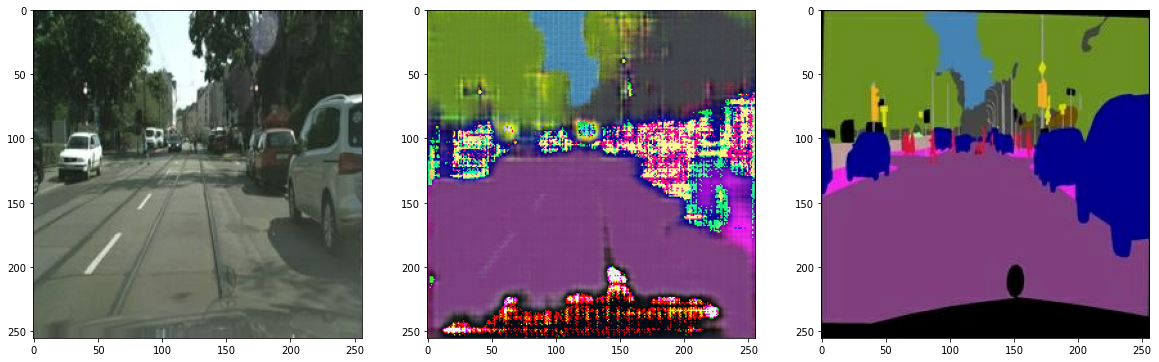

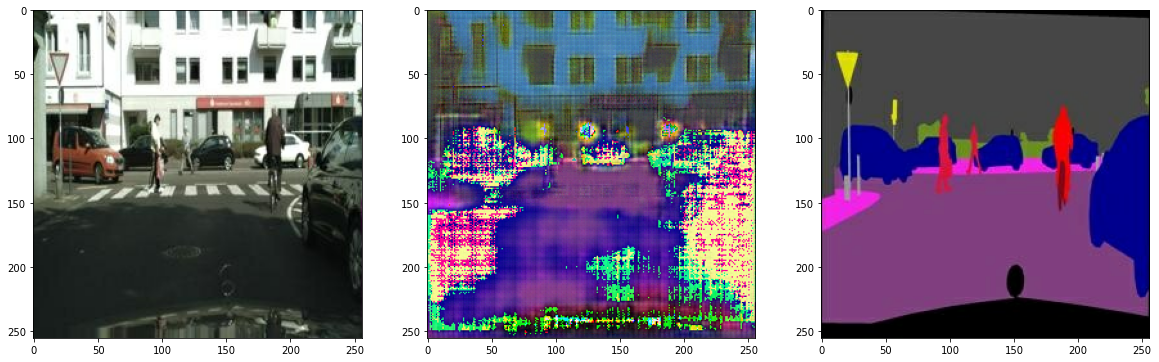

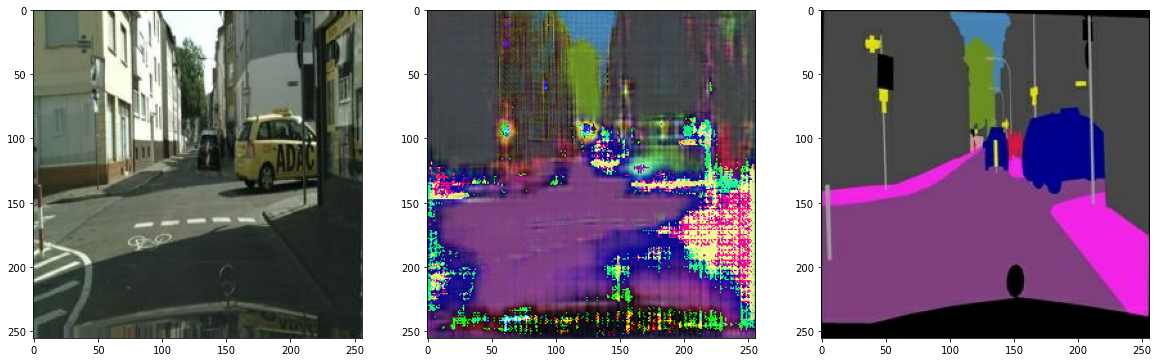

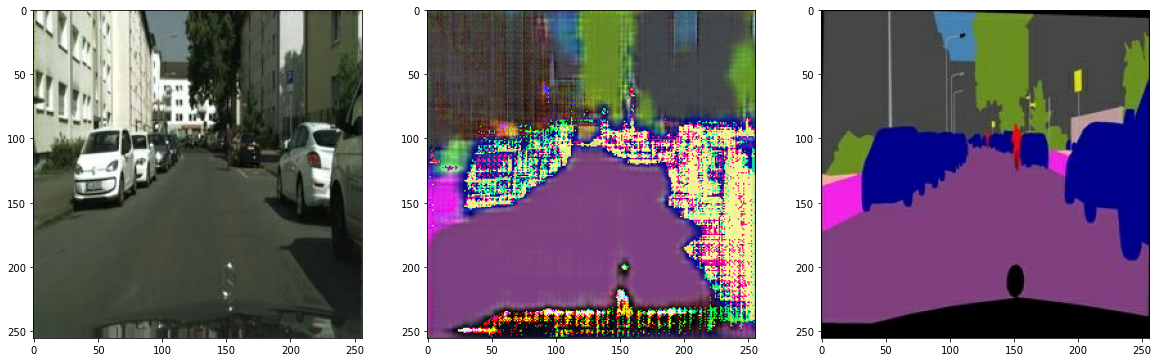

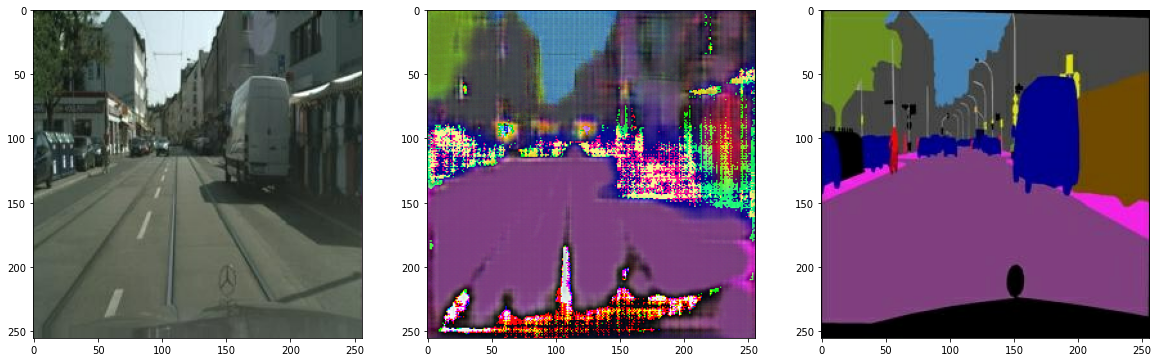

In [32]:
test_ind = 1

for i in range(len(os.listdir(val_data_path))):
    f = val_data_path + os.listdir(val_data_path)[i]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

# 루브릭 평가
---
1. **pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.**   

    - 자르기, 뒤집기, 회전을 적용해 데이터셋을 구축했다. 


2. **pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.**

    - U-Net generator와 discriminator 모델을 구현하였고, train_step은 안정적으로 진행되었다. 
     
     
3. **학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.** 

    - 10 epochs를 학습했고, 도로에 대한 segmentation이 어느정도 잘 생성되었다. 
    - 5장의 validation 이미지를 시각화해 결과를 확인했다. 

    
    
# 회고
---

## 다짐
- U-Net으로 인코딩, 디코딩하는 모델구조가 항상 흥미로웠는데 마지막 프로젝트로 진행할 수 있어서 재미있었다. 또한 이전에 GAN을 공부할 때, 단순히 무작위의 노이즈를 입력으로 넣어서 생성하는 부분이 잘 납득이 가지 않았었는데 이런 점을 벌써 해소해준 Pix2Pix 모델이 있어서 놀랐다. 딥러닝, 머신러닝에서는 어떤 아키텍쳐를 만났을 때 의문점을 갖고 더 발전시킬 수 있는 방안에 대해서 짧게나마 고민하는 방법이 필요하다고 생각한다.